# 手把手教你写决策树 Decision Tree Step by Step

数据来源于我的Github项目。 Data from here:

https://github.com/juwikuang/china_job_survey

我爬了全国的招聘信息，然后以上海为例子，选择了收入最高的25%和最低的25%，以他们作为两类。通过机器学习的分类模型，找出程序员如何成功（成为收入最高的25%）的秘诀。
最近正好朋友介绍了一本书，成功的公式。它也是通过大量数据，找出成功的公式的。我决心好好分析数据，找出程序员成功的Formula。

I collected data from a Chinese job website. Here I use developer jobs in Shanghai with working experience from 3 to 5 years. And our goal is to find the formula of success by big data.

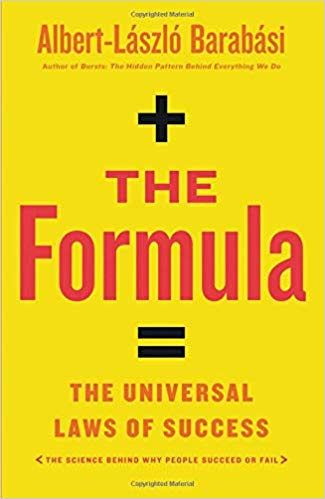

In [8]:
from IPython.display import Image
Image(open("./data/formula.png",mode='rb').read())

In [9]:
import pickle
import numpy as np
import pandas as pd
import random
random.seed(100)

In [10]:
data = pickle.load(open('./data/shanghai_experience_3_5.dmp', mode='rb'))

dataset 说明，

low=工资是否低，low=0表示高工资，low=1表示低工资。这是我们的label，或者说y，或者叫应变量。其他的叫features，或者叫X，或者叫自变量。

注意我这里y是小写，X是大写，因为y是vector，X是matrix

ageism=是否有年龄歧视，我检查招聘信息里面，是否有【岁】字，是则是年龄歧视。

career_algorithm, career_architect, career_software_engineer=这里对职业（career），进行了one-hot-encoding。

其他100多个feature就不一一解释了。这里并不是写论文，等他们出现了再说。

为了简单起见，所有的feature都是bool型的

In this dataset, **low** means the salary is low.

ageism = In the job description, the company require the job candidate to be of certain age. Usuall, below 35 years old. Although, ageism is illegal in most western countries, but it is comom practise in China. China's Huawei once fired a lot of developers who were above 35 years old. One guy commited suicide because of that.

career_algorithm, career_architect, career_software_engineer = one hot encoding of career.

for other 100 and more features, I am not introducing them one by one. This is not a paper.

All features are of boolean type.

In [11]:
data.head()

ageism  career_algorithm  career_architect  career_software_engineer  \
0   False             False             False                      True   
1   False             False             False                      True   
2   False             False             False                      True   
3   False             False             False                      True   
4   False             False             False                      True   

   company_size_10000  company_size_1000_5000  company_size_150_500  \
0               False                   False                 False   
1               False                   False                 False   
2               False                   False                 False   
3               False                   False                 False   
4               False                   False                 False   

   company_size_50  company_size_5000_10000  company_size_500_1000 ...   \
0            False                    False                  False ...    
1            False                    False                  False ...    
2            False                    False                  False ...    
3            False                    False                  False ...    
4            False                    False                  False ...    

   ml_mxnet  ml_chainer  ml_keras  ml_deeplearning4j  ml_theano  ml_sklearn  \
0     False       False     False              False      False       False   
1     False       False     False              False      False       False   
2     False       False     False              False      False       False   
3     False       False     False              False      False       False   
4     False       False     False              False      False       False   

   ml_mahout  ml_paddlepaddle  career_spider  low  
0      False            False          False    1  
1      False            False          False    1  
2      False            False          False    1  
3      False            False          False    1  
4      False            False          False    1  

[5 rows x 128 columns]

In [12]:
data.describe()

low
count  4891.000000
mean      0.541198
std       0.498351
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000

In [13]:
data.shape

(4891, 128)

# 决策树 Decision Tree

决策树Decision Tree(DT)，是通过某种选择机制（entropy或者gini），找到能够把数据分成正负两组的特征。往往需要多次划分，才能得到满意的结果，所以，最后得到的模型，看起来就像一颗树。所以叫决策树。

这个算法，概括的来说，就是不断的寻找一个最优解（最优特征+最优分割点），把数据集一分为二，使集合纯度最高（label为true的和false尽量分开），直到分了n层。

具体来说，就是：

加载数据，遍历每个特征，用每个特征去划分数据集。

这里的特征，可能是bool型的，那就最好了，true的一组，false的一组，直接分成了两组。

也可能是数值型的，那就要把数据从小到大排序，不断的增大切割点的数值，只到找到最优的解。

如果特征是字典型的（categorical，如天气分为晴天，阴天，下雨）的，现在一般是用one-hot-encoding转化成几个bool型。

每个特征的最优解，都是用entropy或者gini表示的，等遍历完了所有的特征，就比较他们的entrop或者gini，选出最优的。

用最优解把数据集一分为二，再对子数据集运用上面的步骤，直到决策树已经达到了一定深度。

Wikipedia:

"A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning."

My words:
A decision tree divides the datasets recursively until certain condition (max depth). When dividing, we examine each feature and calcuate the purity of the new datasets(after devision). We select the  purest division.


# 集合纯度 Purity Evaluation
集合纯度是决策树的难点重点，我们需要找到一种数学方法，去计算集合的纯度。常用的有熵（entropy）和基尼（gini）。

We evaluate purity by entroy or gini impurity.

## Entropy
根据维基百科，信息熵（Information Entropy）的数学定义为：
The function from wikipedia:

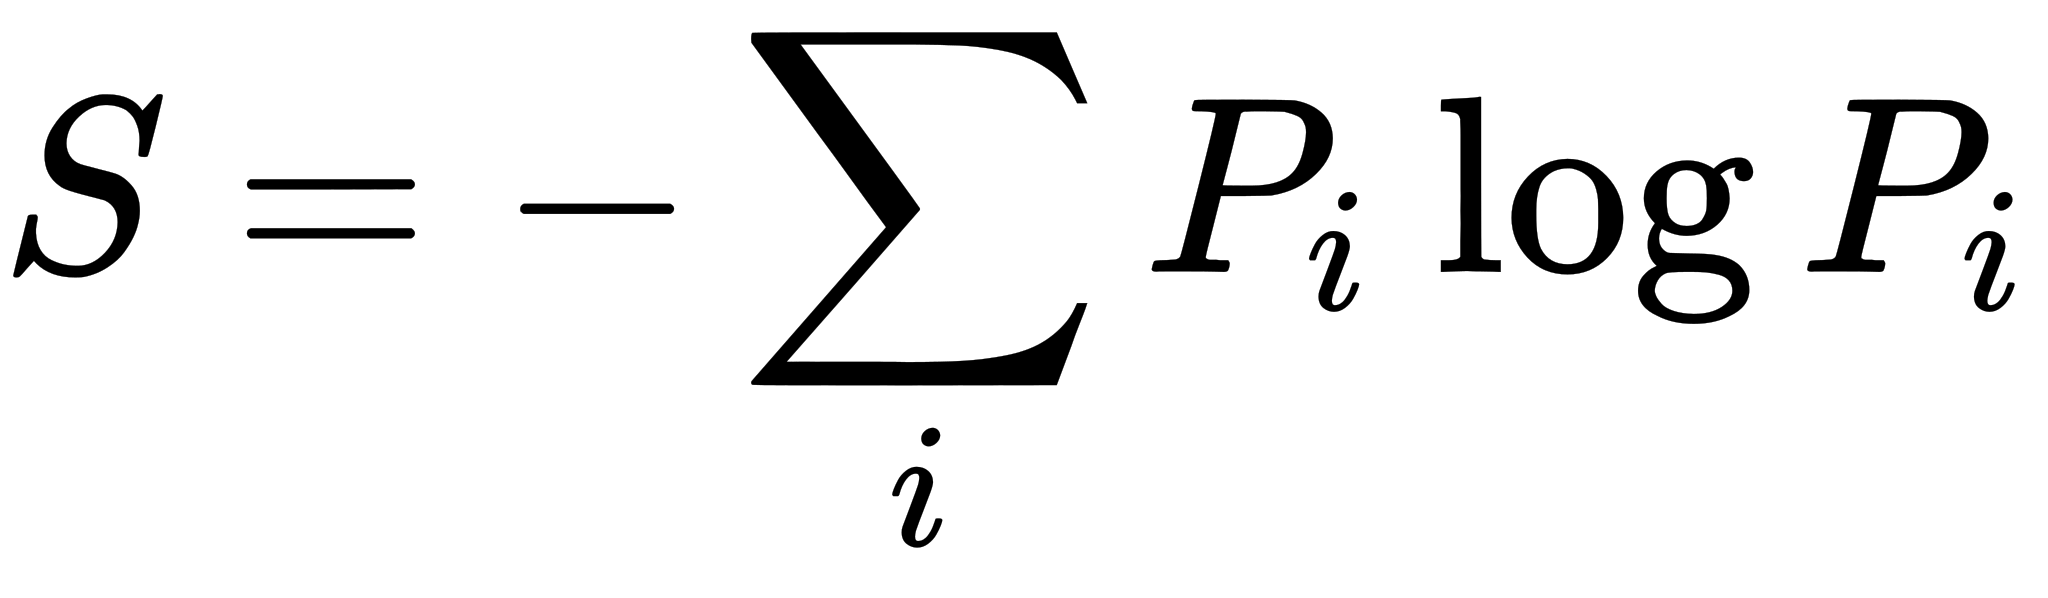

In [14]:
from IPython.core.display import SVG
SVG(filename='./data/entropy.svg')

In [15]:
def information_entropy(counts):
    percentages = counts/np.sum(counts)
    S=0
    for p in percentages:
        if p==0:
            continue
        S=S-(p*np.log2(p))
    return S

这里p表示百分比，S表示信息熵。S越小，数据集的纯度越高。

p = percentage, S=entropy. The smaller the entropy, the purer the dataset.

以我们的数据集为例，假如所有人都是高收入，则S等于0，这时S最小，数据集最纯。
When all the data goes to one side. Entropy = 

In [16]:
information_entropy([0,1])

0.0

假如所有人都是假如高低收入各半，则S等于1，这时S最大，数据集最不纯。 When 50-50:

In [17]:
information_entropy([1/2,1/2])

1.0

那实际情况呢？我们算一下 Let's take a look at our dataset:

In [19]:
n_low=np.sum(data.low==1)
n_low

2647

In [20]:
n_high=data.shape[0]-n_low
n_high

2244

In [21]:
n_rows = data.shape[0]
n_rows

4891

In [22]:
p_low=n_low/n_rows
p_low

0.5411981189940708

In [23]:
p_high=1-p_low
p_high

0.4588018810059292

In [24]:
S=-p_low*np.log2(p_low)-p_high*np.log2(p_high)

In [26]:
S

0.9950971141240397

In [27]:
information_entropy([n_low, n_high])

0.9950971141240397

可见，信息熵接近于1，说明我们数据集的纯度非常低。 The information entropy is close to one, indicating it is very impure.

假如我们用会不会python，把数据集切开。 Let's spilit the developers into two groups, one knows python, the other not.

In [28]:
data_python=data[data.pl_python==1]
data_not_python=data[~data.pl_python==1]

接着，我们分别计算这两组的信息熵 let's calculate the entropy:

In [29]:
def data_entropy(data):
    n_rows=data.shape[0]
    n_low=data[data.low==1].shape[0]
    n_high=n_rows-n_low
    return information_entropy([n_low, n_high])

In [30]:
entropy_python=data_entropy(data_python)
entropy_python

0.889729694070529

In [31]:
entropy_not_python=data_entropy(data_not_python)
entropy_not_python

0.9810034249081002

我们把上面的两个组的熵，按照他们占原数据集的比例，计算出新平均的信息熵如下：

The weighted average entropy:

In [32]:
S_new = data_python.shape[0]/data.shape[0] * entropy_python + data_not_python.shape[0]/data.shape[0] * entropy_not_python
S_new

0.9677537113741245

In [33]:
def data_entropy2(data1, data2):
    entrop1=data_entropy(data1)
    entrop2=data_entropy(data2)
    n1=data1.shape[0]
    n2=data2.shape[0]
    n=n1+n2
    return n1/n*entrop1+n2/n*entrop2

In [34]:
data_entropy2(data_python, data_not_python)

0.9677537113741245

可见，我们用python去划分数据集以后，信息熵变小了，既数据集更纯了。而变小的程度可以用两者的差值表示，既：

the new entropy is 0.97, while the old is 0.98, the dataset becomes more pure. We call the gap information gain:

In [35]:
Gain=S-S_new
Gain

0.027343402749915202

我们把这个差值叫做信息增益。我们每次切割数据集，就是要找出这样一个特征，以它划分数据集，得到的信息增益Gain最大。 This is Information Gain. Our purpose is to find a feature with the max information gain.

现在我们可以去遍历所有的特征，看看谁的Gain最大。
So let's check each feature:

In [36]:
def find_best_feature(data, label):
    X=data.drop(label, axis=1)
    min_entropy=1
    col_selected=''
    data_positive_found=None
    data_negative_found=None
    for col in X.columns:
        data_positive=data[data[col]==1]
        data_negative=data[data[col]==0]
        if data_positive.shape[0]==0:
            continue
        if data_negative.shape[0]==0:
            continue
        entropy=data_entropy2(data_positive, data_negative)
        #print(gain,entropy,entropy_new)
        if entropy<min_entropy:
            min_entropy=entropy
            col_selected=col
            data_positive_found=data_positive
            data_negative_found=data_negative
    return col_selected, min_entropy, data_positive_found, data_negative_found

In [37]:
result=find_best_feature(data, 'low')

In [38]:
gain=S-result[1]
gain

0.06206312569344985

In [39]:
print(result[0])

edu_associate


In [40]:
data.shape

(4891, 128)

Data tells us, education is the most important if you want to earn more salary.

这里，我们得到了，获得高薪的最主要因素，学历！既然这里出现学历了，说明一下我们的数据集包含四种学历（大专，本科，硕士，博士）。associate这个单词表示大专。


In [62]:
data_associate=data[data.edu_associate==1]
data_associate[data_associate.low==0].shape[0]/data_associate.shape[0]

0.23500352858151025

In [63]:
data_not_associate=data[data.edu_associate==0]
data_not_associate[data_not_associate.low==0].shape[0]/data_not_associate.shape[0]

0.5500863557858376

High education leads to high salary.

由此可见，学历高于大专，是获得高薪的最重要因素。
【谁说读书没有用】

## 基尼系数 Gini Impurity
我们也可以用Gini Impurity来判断。这里只给出公式。假设有两个组，平均分配，则Gini Impurity是1-(1/2)^2-(1/2)^2=1/2。而如果全部分配到一边1-0-1=0.所以，gini impurity越小，数据纯度越高。所以它不叫purity（纯度），而叫Impurity（不纯度）。

图片来源于Wikipedia

We can also use Gini Impurity. The function is from wikipedia.

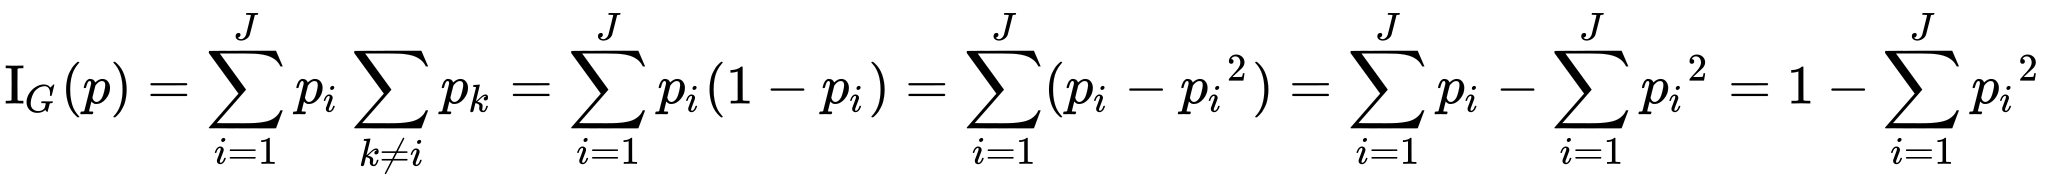

In [64]:
SVG(filename='./data/gini_impurity.svg')

In [65]:
def gini_impurity(counts):
    p_list=counts/np.sum(counts)
    return 1-np.sum(p_list*p_list)

In [66]:
gini_impurity([0,100])

0.0

In [67]:
gini_impurity([50,50])

0.5

# Decision Tree Algorithm 决策树算法
Let's assemble the algorithm.

有了上面的基础，我们就可以写决策树算法了。

split train and test data

In [68]:
msk = np.random.rand(len(data)) < 0.8
data_train=data[msk]
data_test=data[~msk]
X_train=data_train.drop('low', axis=1)
y_train=data_train.low
X_test=data_test.drop('low', axis=1)
y_test=data_test.low


In [69]:
class Branch:
    no=0
    depth=1
    column=''
    entropy=0
    samples=0
    value=[]
    
    branch_positive=None
    branch_negative=None
    no_positive=0
    no_negative=0

In [70]:
number=0

def decision_tree_inner(data, label, depth, max_depth=3):
    global number
    branch = Branch()
    branch.no=number
    number=number+1
    branch.depth=depth
    
    branch.samples=data.shape[0]
    n_positive=data[data[label]==1].shape[0]
    branch.value=[branch.samples-n_positive,n_positive]
    branch.entropy=information_entropy(branch.value)
    best_feature = find_best_feature(data, label)
    branch.column=best_feature[0]
    new_entropy=best_feature[1]
    if depth==max_depth or branch.column=='':
        branch.no_positive=number
        number=number+1
        branch.no_negative=number
        number=number+1
        return branch
    else:
        data_negative=best_feature[3]
        branch.branch_negative=decision_tree_inner(data_negative, label, depth+1, max_depth=max_depth)
        data_positive=best_feature[2]
        branch.branch_positive=decision_tree_inner(data_positive, label, depth+1, max_depth=max_depth)

        return branch

def decision_tree(data, label, max_depth=3):
    number=0
    entropy=data_entropy(data)
    tree=decision_tree_inner(data, label, 0, max_depth=3)
    return tree

In [71]:
my_dt = decision_tree(data_train, 'low', max_depth=2)

## Visualization 可视化
The following code deals with visualization.
以下代码用来可视化decision tree。



In [72]:
def get_dot_data_innner(branch:Branch, classes, dot_data):
    if branch.value[0]<branch.value[1]:
        the_class=classes[0]
    else:
        the_class=classes[1]
    if branch.branch_positive:
        dot_data=dot_data+'{} [label=<{}?<br/>entropy = {:.3f}<br/>samples = {}<br/>value = {}<br/>class = {}> , fillcolor="#FFFFFFFF"] ;\r\n'.format(
            branch.no, branch.column, branch.entropy, branch.samples, branch.value, the_class)
    else:
        dot_data=dot_data+'{} [label=<entropy = {:.3f}<br/>samples = {}<br/>value = {}<br/>class = {}> , fillcolor="#FFFFFFFF"] ;\r\n'.format(
            branch.no, branch.entropy, branch.samples, branch.value, the_class)
    if branch.branch_negative:
        dot_data=dot_data+'{} -> {} [labeldistance=2.5, labelangle=45, headlabel="no"]; \r\n'.format(branch.no, branch.branch_negative.no)
        dot_data=get_dot_data_innner(branch.branch_negative, classes, dot_data)
        
    if branch.branch_positive:
        dot_data=dot_data+'{} -> {} [labeldistance=2.5, labelangle=45, headlabel="yes"]; \r\n'.format(branch.no, branch.branch_positive.no)
        dot_data=get_dot_data_innner(branch.branch_positive, classes, dot_data)
  

    return dot_data
    
def get_dot_data(branch:Branch, classes=['low','high']):
    dot_data="""
digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
"""
    dot_data=get_dot_data_innner(branch, classes,  dot_data)
    dot_data=dot_data+'\r\n}'
    return dot_data

In [73]:
dot_data=get_dot_data(my_dt)

In [74]:
#print(dot_data)

In [75]:
import graphviz 

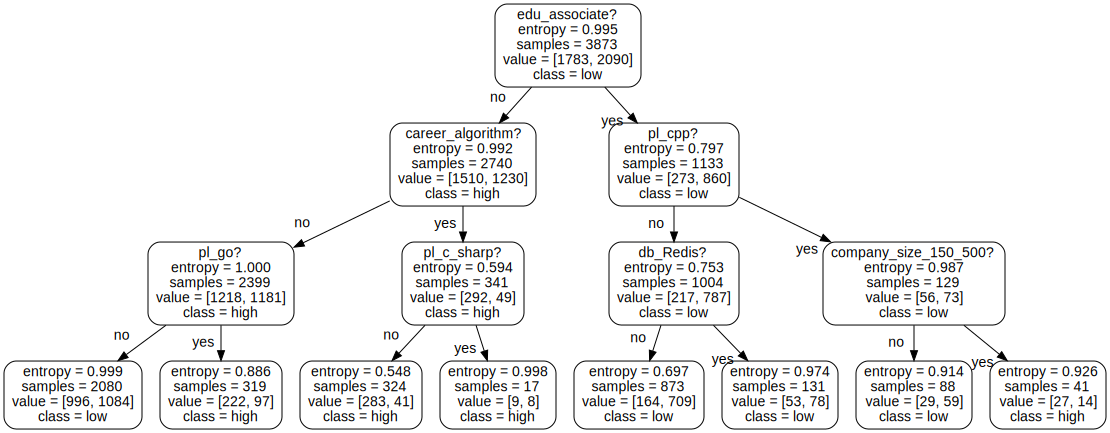

In [76]:
graph = graphviz.Source(dot_data) 
graph.render('./data/my_dt', format='png')
graph

# Decision Tree with Scikit-Learn

In [77]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model=dt.fit(X_train, y_train)

In [78]:
model.score(X_train, y_train)

0.638006713142267

In [79]:
model.score(X_test, y_test)

0.6611001964636543

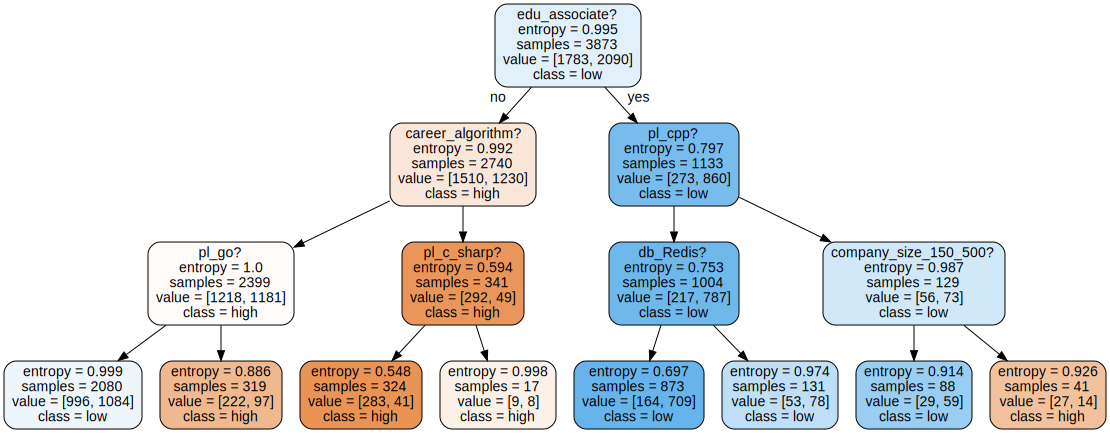

In [80]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(model, out_file=None, 
                      feature_names=X_train.columns,  
                      class_names=['high','low'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
new_dot_data=dot_data.replace('True','no').replace('False','yes').replace(' &le; 0.5','?')
graph = graphviz.Source(new_dot_data) 
graph.render('./data/dt_sklearn', format='png')
graph

# Reference

Decision Tree:

https://en.wikipedia.org/wiki/Decision_tree

Gini Impurity:

https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity

Entropy:

https://en.wikipedia.org/wiki/Entropy_(information_theory)